<a href="https://colab.research.google.com/github/vitroid/PythonTutorials/blob/master/2%20Advanced/055MolSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分子シミュレーション / Molecular Simulations

ここでは、分子シミュレーションに関連したコーディング技法をいろいろ示します。分子シミュレーションそのものについては、教科書等を参考にして下さい。

In this section, we show various coding techniques related to molecular simulation. For more information on molecular simulation itself, please refer to textbooks and other sources.

In [1]:
import numpy as np

## 1. 原子の座標 / Atomic coordinate

原子の座標は$3\times N$次元のnp.arrayで表現すると、あとあと便利です。ここでは例として、$50^3$単純立方格子の座標を生成します。原子間距離は2.5 Åとします。

It is convenient to represent the coordinates of an atom as a $3\times N$-dimensional np.array. As an example, we will generate the coordinates of a $50^3$ simple cubic lattice. The distance between atoms is set to be 2.5 Å.



### 1.1 単純ループ / Simple loop

In [2]:
%%timeit

N = 50
d = 2.5
atoms = []
for ix in range(N):
    for iy in range(N):
        for iz in range(N):
            atoms.append([ix*d, iy*d, iz*d])
atoms = np.array(atoms)


189 ms ± 48.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`%%timeit` repeats runs and estimate the time required for one execution.

### 1.2 リスト内包記法 / list comprehension

In [3]:
%%timeit

N = 50
d = 2.5
atoms = np.array([(ix*d, iy*d, iz*d) for ix in range(N) for iy in range(N) for iz in range(N)])


501 ms ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


numpyのベクトル演算を使いましょう。かけ算はあとでまとめて行います。

Use the vector operations in numpy. Multiplication will be done later.


In [4]:
%%timeit

N = 50
d = 2.5
atoms = d * np.array([(ix, iy, iz) for ix in range(N) for iy in range(N) for iz in range(N)]) 


The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
177 ms ± 80.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.3 `np.arange`

`range()`は整数しか扱えないので、実数版である`np.arange`に代えます。ixなどのループ専用変数が要らなくなる分、直接的な表現といえます。

Since `range()` can only handle integers, it is replaced by `np.range`, which is the real number version of `range()`.

In [5]:
%%timeit

N = 50
d = 2.5
atoms = []
for x in np.arange(0, N*d, d):
    for y in np.arange(0, N*d, d):
        for z in np.arange(0, N*d, d):
            atoms.append([x, y, z])
atoms = np.array(atoms)

114 ms ± 37.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


一般に、リスト内包記法は通常のループよりも高速です。

In general, the list comprehension is faster than normal loops.

In [6]:
%%timeit

N = 50
d = 2.5
atoms = np.array([(x,y,z) for x in np.arange(0, N*d, d) for y in np.arange(0, N*d, d) for z in np.arange(0, N*d, d)])


116 ms ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.4 `meshgrid`

numpyには、格子を生成するための特別な関数がいくつかあります。meshgridは、X,Y,Z軸方向の目盛から、格子点を一気に生成します。

まず、X方向の目盛を作ります。

Numpy has several special functions for generating lattices. The `meshgrid` generates lattice points from X-, Y-, and Z-axis ticks all at once.

First, we create a sequence in the X direction.

In [7]:
N = 50
d = 2.5
X = np.arange(0, N*d, d)
X

array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
       112.5, 115. , 117.5, 120. , 122.5])

同様に、Y, Zも生成し、これらを組みあわせてグリッド(格子)を作ります。

Similarly, Y and Z are generated and combined to form a grid (lattice).

In [8]:
Y = np.arange(0, N*d, d)
Z = np.arange(0, N*d, d)

Xg,Yg,Zg = np.meshgrid(X,Y,Z, indexing="ij")
Xg

array([[[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        ...,
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5]],

       [[  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        ...,
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5

Xgの中身は、Xの内容がなんどもリピートされているように見えます。しかも3次元配列ですね。では、個々の要素を見ていきます。

The contents of Xg look like the contents of X are repeated over and over. And it is a 3-dimensional array. Now let's look at the individual elements.

In [9]:
Xg[0,0,0], Yg[0,0,0], Zg[0,0,0]

(0.0, 0.0, 0.0)

In [10]:
Xg[3,2,4], Yg[3,2,4], Zg[3,2,4]

(7.5, 5.0, 10.0)

わかるでしょうか。`Xg[i,j,k]`には、$(i,j,k)$番目の格子点のX座標が入っています。

三次元配列ではなく、以前の例のような座標の単純な羅列が欲しいなら、flatten()関数で1次元化します。

As you see, `Xg[i,j,k]` contains the X coordinates of the $(i,j,k)$-th grid point.

If you want a simple list of coordinates as in the previous example, instead of a three-dimensional array, you can make it one-dimensional with the flatten() function.

In [45]:
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
Xf.shape

(125000,)

全部まとめると次のように書けます。

Let's make them together.

In [12]:
%%timeit

N = 50
d = 2.5
X = np.arange(0, N*d, d)
Y = np.arange(0, N*d, d)
Z = np.arange(0, N*d, d)
Xg, Yg, Zg = np.meshgrid(X,Y,Z)
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
atoms = np.array([Xf,Yf,Zf]).T


1.61 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


読みにくくなりますが、ループがまったくないので爆速です。

It is hard to read, but is much faster.

### 1.5 `mgrid`

`mgrid`は`meshgrid`と似た働きをしますが、関数ではなく配列のように見えます。

`mgrid` works similarly to `meshgrid`, but looks like an array rather than a function.

In [13]:
%%timeit 

N = 50
d = 2.5
Xg, Yg, Zg = np.mgrid[0:N,0:N,0:N]
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
atoms = d * np.array([Xf,Yf,Zf]).T


7.35 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


極限まで簡略化するとこんな感じ。もはや読めませんが、関数にして名前をつけておけば無問題です。

It is not easy to read, but if you make it a function and give it a name, there is no problem.

In [46]:
%%timeit

def simple_lattice(N):
    """Generates a simple cubic lattice with a nearest-neighbor interatomic distance of 1.
    N: Generates N^3 unit cells.

    最近接原子間距離が1の単純立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    return np.mgrid[0:N, 0:N, 0:N].reshape(3,-1).T

N = 50
d = 2.5
atoms = simple_lattice(N)*d


2.1 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)



### 1.5 ほかの格子 / Other lattices

体心立方格子は、単純立方格子を$(1/2, 1/2, 1/2)$だけずらして重ねたものといえます。

まず、間隔1の単純格子をつくります。

A body-centered cubic lattice can be made of two simple cubic lattices stacked with $(1/2, 1/2, 1/2)$ shifts.

First, a simple lattice with spacing 1 is created.

In [15]:
def simple_lattice(N):
    """Generates a simple cubic lattice with a nearest-neighbor interatomic distance of 1.
    N: Generates N^3 unit cells.

    最近接原子間距離が1の単純立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    return np.mgrid[0:N, 0:N, 0:N].reshape(3,-1).T

N = 50
atoms = simple_lattice(N)
atoms

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [49, 49, 47],
       [49, 49, 48],
       [49, 49, 49]])

ずらした格子を別途作ります。

Prepare another slid lattice.

In [16]:
slid = atoms + np.array([0.5, 0.5, 0.5])
slid

array([[ 0.5,  0.5,  0.5],
       [ 0.5,  0.5,  1.5],
       [ 0.5,  0.5,  2.5],
       ...,
       [49.5, 49.5, 47.5],
       [49.5, 49.5, 48.5],
       [49.5, 49.5, 49.5]])

そして2つを連結concatします。

And concatenate them.

In [17]:
bcc = np.concatenate([atoms, slid])
bcc

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  2. ],
       ...,
       [49.5, 49.5, 47.5],
       [49.5, 49.5, 48.5],
       [49.5, 49.5, 49.5]])

最近接格子間距離を2.5 Åにしたいなら、ちょっと工夫が必要です。最近接原子は$(0,0,0)$と$(1/2,1/2,1/2)$にあります。この距離が2.5 Åになるように調節します。

As we want a BCC with minimal separation of 2.5 Å, we scale the lattice.


In [18]:
d = 2.5
bcc * d * 2 / 3**0.5

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   2.88675135],
       [  0.        ,   0.        ,   5.77350269],
       ...,
       [142.89419162, 142.89419162, 137.12068893],
       [142.89419162, 142.89419162, 140.00744028],
       [142.89419162, 142.89419162, 142.89419162]])

最後に、これも関数にしておきます。

Finally, we make it a function.

In [19]:
def BCC(N):
    """Generates a body centered cubic lattice with a nearest-neighbor interatomic distance of 1.
    N: Generates N^3 unit cells.

    最近接原子間距離が1の体心立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    atoms = simple_lattice(N)
    slid = atoms + np.array([0.5, 0.5, 0.5])
    return np.concatenate([atoms, slid]) * 2 / 3**0.5

N = 50
d = 2.5
atoms = BCC(N) * d
atoms

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   2.88675135],
       [  0.        ,   0.        ,   5.77350269],
       ...,
       [142.89419162, 142.89419162, 137.12068893],
       [142.89419162, 142.89419162, 140.00744028],
       [142.89419162, 142.89419162, 142.89419162]])

関数定義の直後にある文字列は、関数の説明文です。これを定義しておくと、ヘルプに表示されます。

In [20]:
?BCC

### Practice 1

最短原子間距離が1の面心立方格子を生成する関数fccを作り、単位格子数$2^3$で最短原子間距離が2.5 Åの面心立方格子を作って下さい。

Write a function `fcc` that produces a face-centered cubic lattice with a shortest interatomic distance of 1, then make a lattice consisting of $2^3$ unit cells and with a shortest interatomic distance of 2.5 Å.

## 2. シミュレーションセルの取扱い / Simulation cell

分子シミュレーションはほとんどの場合周期境界条件のもとで行われます。周期境界条件を適用しない場合、必ず表面の影響を受けてしまいますが、周期境界条件により表面のない状況を擬似的に表現できます。

分子シミュレーションでは、分子の入っている箱のことをシミュレーションセルまたは単にセルと呼びます。セルは立方体の場合もあれば直方体の場合もあります。気体や液体のシミュレーションでは立方体セルを使うことが多いですが、固体の場合には結晶の形によっては直方体や平行六面体のセルを用いる場合もあります。

セルの大きさについてはここでは議論しませんが、あまり小さな系はアーティファクトの原因になります。最近では1万分子以上を含むような、大規模なシミュレーションも一般的になってきています。

以下ではシミュレーションセルは一般的に平行六面体であると考え、その3つの辺を$(\vec a, \vec b, \vec c)$あるいは`a,b,c`で表記します。

Most molecular simulations are performed under periodic boundary conditions. If the periodic boundary condition is not applied, the simulation will always be affected by the surface, but the periodic boundary condition can be used to simulate a surface-free situation.

In molecular simulations, the box containing the molecules is called a simulation cell or simply a cell. The cell may be cubic or rectangular. Cubic cells are often used in gas and liquid simulations, but for solids, depending on the shape of the crystals, rectangular or parallelepipedal cells may be used.

The size of the cell is not discussed here, but too small systems can cause artifacts. It has become common to use large simulations that include more than 10,000 molecules.

In the following, the simulation cell is generally considered to be a parallelepiped and its three edges are denoted by $(\vec a, \vec b, \vec c)$ or `a,b,c`.

### 2.1 絶対座標系とセル相対座標系 / Absolute and fractional coordinate system

セル内の原子の座標を表す方法として、絶対座標(ユークリッド座標)を指定する方法と、セル相対座標(fractional coordinate)を指定する方法があります。

例えば、一辺が12 Åのシミュレーションセルのすみ(原点)と、中央にいる原子の座標は、絶対座標では$(0,0,0), (6,6,6)$、セル相対座標では$(0,0,0), (0.5, 0.5, 0.5)$となります。

直感的にわかりやすいのは前者ですが、周期境界条件のとりあつかいを考えると、後者のほうが圧倒的に便利です。

直方体セルの場合、セル相対座標を絶対座標に変換するには、セル長をかけます。逆に、絶対座標をセル長で割れば、セル相対座標になります。

There are two ways to express the coordinates of atoms in a cell: one is to specify absolute coordinates (Euclidean coordinates) and the other is to specify cell-relative coordinates (fractional coordinates).

For example, the coordinates of the origin and the atom in the center of a cubic 12 Å simulation cell are $(0,0,0), (6,6,6)$ in absolute coordinates and $(0,0,0), (0.5, 0.5, 0.5)$ in cell relative coordinates.

The former is intuitively easier to understand, but the latter is by far more convenient when considering the handling of periodic boundary conditions.

In the case of a rectangular cell, relative cell coordinates are converted to absolute coordinates by multiplying by the cell length. Conversely, dividing absolute coordinates by cell length yields cell relative coordinates.

In [21]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
B = np.array([6.0, 6.0, 6.0])

rA = A / cell
rB = B / cell
rA, rB

(array([0., 0., 0.]), array([0.5, 0.5, 0.5]))

### 2.2 周期境界条件下での原子間距離の計算 / Atomic distance under PBC

2つの原子の距離は、座標からピタゴラスの定理を使って計算できます。

The distance between two atoms can be calculated from their coordinates using the Pythagorean theorem.

In [22]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
B = np.array([3.0, 3.0, 3.0])

dAB = B - A
r = (dAB[0]**2 + dAB[1]**2 + dAB[2]**2)**0.5
r

5.196152422706632

でも、次の場合にはこの方法はうまくいきません。

But it is wrong in the following case.

In [23]:
A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

dAC = C - A
r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

15.588457268119896

周期境界条件のもとでは、AB間の距離はAC間の距離と同じはずですが、AC間の計算ではイメージセル間の最短距離をとらえそこねています。

ちゃんと計算するには、条件分岐が必要になります。

Under the periodic boundary condition, the distance between AB should be the same as the distance between AC, but the calculation between AC fails to capture the shortest distance between image cells.

To calculate it properly, a conditional branch is required.

In [24]:
A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

dAC = C - A

if dAC[0] < -6.0:
    dAC[0] += 12
elif dAC[0] > +6.0:
    dAC[0] -= 12

if dAC[1] < -6.0:
    dAC[1] += 12
elif dAC[1] > +6.0:
    dAC[1] -= 12

if dAC[2] < -6.0:
    dAC[2] += 12
elif dAC[2] > +6.0:
    dAC[2] -= 12

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

これは面倒臭い! 上の条件式にでてくる6.0はセルの一辺の長さの半分です。差が6を越えたら、反対側のイメージセルの原子のほうが近いので、12を引いてイメージセルの原子との距離におきかえます。これを3方向について処理する必要があります。

次に、同じことをセル相対座標で書いてみます。

This is tedious! The 6.0 in the above equation is half the length of one side of the cell. If the difference exceeds 6, the atom in the image cell on the opposite side is closer, so we subtract 12 and replace it with the distance to the atom in the image cell. This must be done for all three directions.

Next, let us write the same thing in cell relative coordinates.

In [25]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

# to a fractional coordinate
rA = A / cell
rC = C / cell

dAC = rC - rA

if dAC[0] < -0.5:
    dAC[0] += 1
elif dAC[0] > +0.5:
    dAC[0] -= 1

if dAC[1] < -0.5:
    dAC[1] += 1
elif dAC[1] > +0.5:
    dAC[1] -= 1

if dAC[2] < -0.5:
    dAC[2] += 1
elif dAC[2] > +0.5:
    dAC[2] -= 1

# to an absolute displacement vector
dAC *= cell

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

やっていることは同じですが、セルサイズが条件文の中にでてこなくなったので、すこし見易くなりました。

でもメリットはこれだけではありません。条件文の計算は、実は「四捨五入」と等価なのです。例えば、`x==0.75`なら、上の条件文を通ると`x==-0.25`になりますよね。これは、「xを小数点1桁目で四捨五入して、xから引く」のと同じ結果になります。

numpyには四捨五入関数round()が準備されていますから、これを使うとプログラムはさっぱりします。

What is done is the same, but the cell size is no longer shown in the conditional statement, so it is a little easier to read.

But this is not the only benefit. The conditional statement calculation is actually equivalent to rounding. For example, if `x==0.75`, then `x==-0.25` after passing the conditional statement above. This is the same result as rounding x to the first decimal place and subtracting from x itself.

Since numpy is prepared with a rounding function round(), you can rewrite your program with it.

In [26]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

# fractional coordinate
rA = A / cell
rC = C / cell

dAC = rC - rA
dAC -= np.round(dAC)

# absolute displacement vector
dAC *= cell

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

> なお、著者は`round()`関数の挙動が気持ち悪いので、`floor(x+0.5)`という書き方を好みます。`round()`の気持ち悪さは下のグラフで実感できます。

> Note that the author prefers to write `floor(x+0.5)` because the behavior of the `round()` function is weird. The weirdness of `round()` can be seen in the graph below.

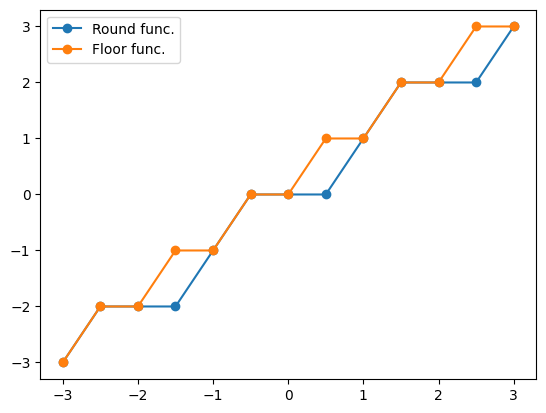

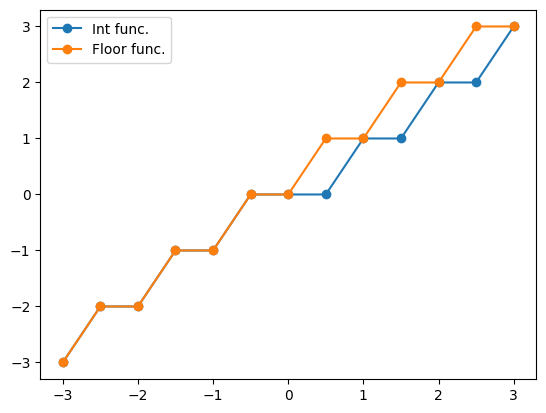

In [27]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-3.0, +3.5, 0.5)
plt.plot(x, np.round(x), "o-",  label="Round func.")
plt.plot(x, np.floor(x+0.5), "o-", label="Floor func.")
plt.legend()
plt.show()

plt.plot(x, x.astype(int), "o-", label="Int func.")
plt.plot(x, np.floor(x+0.5), "o-", label="Floor func.")
plt.legend()
plt.show()


### 2.3 セルからはみでた原子の扱い / Atoms out of the cell

分子動力学シミュレーションの過程で、原子がセル端面を越えて外に出てしまう場合があります。その場合は、反対側から入ってきます。

絶対座標で書くと以下のような感じです。

During the course of a molecular dynamics simulation, an atom may go out past the cell end face. In that case, it comes in from the other side.

Written in absolute coordinates, it looks like this:

In [28]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

if A[0] < 0.0:
    A[0] += 12
elif A[0] > 12:
    A[0] -= 12

if A[1] < 0.0:
    A[1] += 12
elif A[1] > 12:
    A[1] -= 12
    
if A[2] < 0.0:
    A[2] += 12
elif A[2] > 12:
    A[2] -= 12
    
A

array([1., 2., 9.])

これも、セル相対座標を使えばすこし簡潔になります。

The fractional coordinates make it simpler.

In [29]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

# to a fractional coordinate
rA = A / cell

if rA[0] < 0.0:
    rA[0] += 1
elif rA[0] > 1:
    rA[0] -= 1

if rA[1] < 0.0:
    rA[1] += 1
elif rA[1] > 1:
    rA[1] -= 1
    
if rA[2] < 0.0:
    rA[2] += 1
elif rA[2] > 1:
    rA[2] -= 1

# to an absolute coordinate
A = rA * cell   
A

array([1., 2., 9.])

今度は条件分岐のしかたがちょっと違いますね。この条件分岐は、切り捨てに書きなおすことができます。

* zは-0.25。(-3/12)
* zを小数点以下で切り捨てる=zよりも小さい最大の整数にする=-1
* もとのzから-1を引くと0.75。

This time, the conditional branch is a little different. This conditional branch can be rewritten to a truncation.

* z is -0.25.(-3/12)
* truncate z to the nearest whole number (= the largest integer less than z) = -1
* Subtract -1 from the original, z = 0.75.



In [30]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

# to a fractional coordinate
rA = A / cell

# 切りすてた数をもとの数から引く。
rA -= np.floor(rA)

# to an absolute coordinate
A = rA * cell   
A

array([1., 2., 9.])

このように、セル相対座標を使うことで、条件分岐を使わないですみ、プログラムが簡潔かつ高速になります。

Thus, using cell relative coordinates eliminates the need for conditional branching, making the program simpler and faster.

### 2.4 非直方体セルの取扱い / not orthogonal cell

直方体でないセルのことも考えると、絶対座標よりセル相対座標のほうが圧倒的に便利であることがわかります。

直方体でないセルの、3つの辺をそれぞれ$\vec a, \vec b, \vec c$で表します。

さて、このセルの中央に原子をひとつ置いて下さい。もし絶対座標を使うのなら、中心とは$\vec a+ \vec b+ \vec c\over 2$のことです。

Considering non-rectangular cells, we find that cell relative coordinates are by far more convenient than absolute coordinates.

Let $\vec a, \vec b, \vec c$ denote the three basic vectors of a nonrectangular cell, respectively.

Now, place one atom in the center of this cell. If we use absolute coordinates, it is $\vec a+ \vec b+ \vec c\over 2$.

In [31]:
a = np.array([3.0, 0.0, 0.0])
b = np.array([1.5, 4.0, 0.0]) # bが傾いている
c = np.array([0.0, 0.0, 5.0])

A = (a+b+c)/2
A


array([2.25, 2.  , 2.5 ])

では、絶対座標で$(0.5, 2.0, 3.0)$にある原子Bは、このセルの中にありますか? それとも外にありますか? 外にある場合、周期境界条件のもとでセル内に移動させるならどこに来るでしょうか。

かなり面倒に見えてきましたね。そこでセル相対座標の出番です。

セル相対座標では、その名の通り、原子の場所はセルの中での相対位置で指示します。例えば、セルの中心は、セルの形がどんなであっても$(0.5, 0.5, 0.5)$です。そして、絶対座標になおしたいなら、
$0.5\vec a+0.5 \vec b+0.5\vec c$を計算すればいいだけです。

もっと簡単に書く方法を教えましょう。セルの3基本ベクトルを束ねた、セル行列というものを作ります。

$$M=\left(\begin{array}{c}
a_x&b_x&c_x\\
a_y&b_y&c_y\\
a_z&b_z&c_z
\end{array}\right)$$

そして、これにセル相対ベクトル$\vec v=(1/2,1/2,1/2)^T$をかけます。($^T$は転置を表します。$\vec v$は縦ベクトルです)
$$ \vec w=M\cdot \vec v$$
$$=\left({a_x+b_x+c_x\over 2}, {a_y+b_y+c_y\over 2}, {a_z+b_z+c_z\over 2}\right)$$

得られた$\vec w$はセル中心の絶対座標になっています!

ということは、逆に絶対座標に$M$の逆行列をかけるだけで、セル相対座標に変換できる、ということになります。

$$ \vec v=M^{-1}\cdot \vec w$$

なお、numpyでは座標ベクトルは横ベクトルで表されることが多いので、全部転置したほうが便利です。

$$ \vec w^T=\vec v^T\cdot M^T$$
$$ \vec v^T=\vec w^T\cdot (M^{-1})^T$$

----

So is atom B at absolute coordinates $(0.5, 2.0, 3.0)$ inside this cell? Or is it outside? If it is outside, where its the right position for B under periodic boundary conditions?

In the fractional coordinate, it is an easy task.

In cell relative coordinates, as the name implies, the location of an atom is indicated by its relative position in the cell. For example, the center of a cell is $(0.5, 0.5, 0.5)$ no matter what the shape of the cell is. And if you want to convert it to absolute coordinates,
Just calculate $0.5\vec a+0.5 \vec b+0.5\vec c$.

Let me show you an easier way to write it. We create a cell matrix, which is a bundle of 3 basis vectors of cells.

$$M=\left(\begin{array}{c}
a_x&b_x&c_x\\
a_y&b_y&c_y\\\
a_z&b_z&c_z
\end{array}\right)$$

Then multiply this by the cell relative vector $\vec v=(1/2,1/2,1/2)^T$. ($^T$ denotes transposition. $\vec v$ is a vertical vector)
$$ \vec w=M\cdot \vec v$$
$$=\left({a_x+b_x+c_x\over 2}, {a_y+b_y+c_y\over 2}, {a_z+b_z+c_z\over 2}\right)$$

The obtained $\vec w$ are absolute coordinates of the cell center!

This means that, conversely, we can convert it to cell relative coordinates by simply multiplying the absolute coordinates by the inverse matrix of $M$.

$$ \vec v=M^{-1}\cdot \vec w$$

Note that in numpy, coordinate vectors are often represented as transversal vectors, so it is more convenient to transpose them all.

$$ \vec w^T=\vec v^T\cdot M^T$$
$$ \vec v^T=\vec w^T\cdot (M^{-1})^T$$



In [32]:
Mt = np.array([a,b,c]) # 転置されたセル行列

vt = np.array([0.5,0.5,0.5])
wt = vt @ Mt
wt

array([2.25, 2.  , 2.5 ])

In [33]:
MtI = np.linalg.inv(Mt)

vt = wt @ MtI
vt

array([0.5, 0.5, 0.5])

セル相対座標表示のメリットはほかにもまだまだあります。

ある原子がセルからはみでているかどうかは、セル相対座標であれば、座標値が0〜1の範囲にあるかどうかだけで判別できます。

There is still anoother advantage of the fractional coordinate.

In the fractional coordinates, it is possible to determine whether an atom is out of a cell or not, simply by whether the coordinate value is in the range of 0 to 1.

In [34]:
B = np.array([0.5,2.0,3.0]) #絶対座標
rB = B @ MtI
rB

array([-0.08333333,  0.5       ,  0.6       ])

Bはセル外にあります。では、周期境界条件を作用させて、セル内に移動させるには?

これも上で紹介した切り捨て法がそのまま使えます。

B is out of the cell because its fractional x coordinate is negative. Then, where is the correct position?

The truncation method is also useful here.

In [35]:
rB -= np.floor(rB)
rB

array([0.91666667, 0.5       , 0.6       ])

そして絶対座標に戻したければ、セル行列をかけます。

And multiply the cell matrix when the absolute coordinate is required.

In [ ]:
B = rB @ Mt
B

周期境界条件のもとでの2つの原子の相対ベクトルも、同じように簡単に計算できます。

The relative vector between two atoms in a non orthogonal cell can also be calculated easily in the same way.


In [ ]:
B = np.array([0.5,2.0,3.0]) #絶対座標
rB = B @ MtI

rA = np.array([0.5,0.5,0.5]) # 相対座標でセルの中央

rel = rB - rA                # 相対座標での差
rel -= np.floor(rel+0.5)     # 相対座標での周期境界条件の作用

rel @ Mt  # 絶対座標における相対位置ベクトル

Gromacsの.groファイルでは、原子座標を絶対座標で記録しますが、それが最良なわけではありません。LAMMPSやCIFはセル相対座標を使います。周期境界条件に関係ある処理を行う場合は、原子の座標を全部セル相対座標に変換しておくと、何かと便利です。

groファイルを読みこみ、セル行列とセル相対座標を生成するMDAnalysisのサンプルコードを下に書いておきます。

Gromacs .gro files record atomic coordinates in absolute coordinates, but that is not always the best; LAMMPS and CIF use cell relative coordinates. If you are doing a process that involves periodic boundary conditions, it may be useful to convert all of the atom coordinates to cell relative coordinates.

Below is a sample code for MDAnalysis that reads a gro file and generates cell matrices and cell relative coordinates.

In [ ]:
%pip install mdanalysis

In [ ]:
import MDAnalysis as mda

with open("data.gro") as file:
    # MDAnalysisオブジェクト
    u = mda.Universe(file, format="GRO")
    # 酸素原子だけ抽出。単位はÅ 
    O = u.select_atoms("name OW")
    # 転置されたセル行列
    cell = mda.lib.mdamath.triclinic_vectors(u.trajectory.ts.dimensions).T
    # その逆行列
    celli = np.linalg.inv(cell)
    # 酸素原子の座標を抽出(絶対座標)
    pos = O.atoms.positions.astype(float)
    # セル相対座標に変換
    rpos = pos @ celli


## 3. 原子対の取扱い / Neighbor pairs

各原子から$n$ nm以内にある原子を抽出して処理を行いたい、ということはよくあります。例えば、1 nmまでの動径分布関数を計算したい場合であれば、各原子から1 nmより遠い原子について何らかの処理を行うのは無駄でしかありません。

最初に作った体心立方格子の原子配置を使い、隣接する原子間を結合でつないでみましょう。

It is often the case that we want to extract and process atoms that are within $n$ nm of each atom. For example, if we want to calculate radial distribution functions upto 1 nm, it would be wasteful to do any processing on atoms farther than 1 nm from each atom.

Let's use the atomic arrangement of the body-centered cubic lattice we created at the beginning to connect adjacent atoms with a bond.

In [47]:
import numpy as np

def simple_lattice(N):
    return np.mgrid[0:N, 0:N, 0:N].reshape(3,-1).T

def BCC(N):
    atoms = simple_lattice(N)
    slid = atoms + np.array([0.5, 0.5, 0.5])
    return np.concatenate([atoms, slid]) * 2 / 3**0.5

N = 12
d = 2.5
atoms = BCC(N) * d
len(atoms)

3456

atomsには、3456個の原子の座標が含まれています。そして、最近接原子距離は2.5です。2つの原子の間の距離が3.0以下であれば結合していると判定して、原子の番号をリストに蓄えていくことにしましょう。

とりあえず、周期境界条件のことは無視します。

最も素朴なコードは次のようなものです。

`atoms` contains the coordinates of 3456 atoms. And the nearest-neighbor atom distance is 2.5. let's determine that two atoms are bonded if the distance between them is less than 3.0 and store the atom numbers in the list.

For now, we will ignore the periodic boundary condition.

The most elementary code would look something like this

In [37]:
def all_pairs(atoms, rc):
    nmol = len(atoms)
    pairs = []
    for i in range(nmol):
        for j in range(i):
            d = atoms[j] - atoms[i]
            r2 = (d**2).sum()
            if r2 < rc**2:
                pairs.append([i,j])
    return pairs

%time print(len(all_pairs(atoms, 3.0)))


21671
CPU times: user 24.4 s, sys: 42.7 ms, total: 24.5 s
Wall time: 24.7 s


... たった20000対のリストを作るのに、うんざりするぐらい待たされますね。しかも、まだ周期境界条件の処理を行っていません。粒子数の二乗に比例するアルゴリズムは、粒子数が10000を越えるとまず使いものにならないということです。

そこで、あらかじめすべての粒子をbinに分け、その上で対リストを作ることにします。とりあえず、binの大きさは1 Åとしましょう。

これぐらい細かくしておけば、同じbinの中に複数の原子が入ることはまずありません。(共有結合する物質ではもっと細かくしたほうがいいですが、それはあとで考えます。)


... It is exasperatingly long time to obtain a list of only 20,000 pairs. And we have not yet processed the periodic boundary conditions. The algorithm proportional to the square of the number of particles means that it is useless if the number of particles exceeds 10,000.

Therefore, we will divide all particles into bins and make a pair list. For now, we set the bin size to be 1 Å.

It is unlikely that more than one atom will be in the same bin.



In [38]:
# occupant[x]はbin xにある原子の番号
occupant = dict()
i = 0
for pos in atoms:
    # 座標を整数にする; pos=(1.4, 3.2, -6.3)ならipos=(1, 3, -7)
    ipos = tuple(np.floor(pos).astype(int))
    # binに、原子の番号を入れておく。(あとで、その場所にいる原子の番号を知りたいので)
    occupant[ipos] = i
    i += 1

上のコードでは、occupantをdict()としているのがミソです。これによって、粒子が入っていないbinまで準備する必要がなくなります。

例えば、ある原子Aの近く、3 Å以内にある原子を全部知りたいなら、次のようにさがします。

1. Aのbin番号を求めます。これを`(p, q, r)`とします。
2. binの間隔は1 Åなので、そのbinから、3つ隣までのbin (つまり、`(p-3:p+4,q-3:q+4,r-3:r+4)`)に入っている原子は、距離3 Å以内にある可能性があります。
3. それらの中で、実際に3 Å以内にあるものだけを抽出します。

In the code above, the key is to use dict() for occupant. This eliminates the need to prepare bins that do not contain any particles.

For example, if you want to know all the atoms within 3 Å of an atom A, you can do the following: 

1. Let `(p, q, r)` the bin number that contains A.
2. Since the distance between the bins is 1 Å, the atoms in the next three bins (i.e., `(p-3:p+4,q-3:q+4,r-3:r+4)`) may be within a distance of 3 Å from the bin. Pick them up all. It is a rough estimate.
3. Extract atoms are actually within 3 Å.

In [39]:
def nearby(A, radius, atoms, occupant):
    """
    A: The target atom
    radius: maximum separation distance
    atoms: absolute coordinates of the atoms
    occupant: list of atoms in each bins
    """
    # 整数化した座標 = bin番号
    p,q,r = np.floor(atoms[A]).astype(int)
    # 距離を整数にしたもの。いくつ隣のbinまでさがすかを決める。
    # 見逃しを避けるために、切り上げる。
    iradius = np.ceil(radius).astype(int)

    near = []
    # bin (p,q,r)に近いbinだけを探す。
    for ix in range(p-iradius, p+iradius+1):
        for iy in range(q-iradius, q+iradius+1):
            for iz in range(r-iradius, r+iradius+1):
                if (ix,iy,iz) in occupant:
                    # 隣接原子の候補
                    B = occupant[ix,iy,iz]
                    # 自分を含めない、かつ重複を避ける
                    if A < B:
                        # きちんと距離を計算する
                        d = atoms[A] - atoms[B]
                        # 近ければ
                        if (d**2).sum() < radius**2:
                            # リストに追加する
                            near.append(B)
    return near



3 Å以内の原子対をリストします。

List all pairs within 3 Å.

In [40]:
pairs = []
for i in range(len(atoms)):
    near = nearby(i, 3.0, atoms, occupant)
    for j in near:
        pairs.append([i,j])

len(pairs)

21671

全部まとめて時間を測ってみましょう。速さは明らかです。また、この手法だと粒子数Nに比例した時間しかかからないので、粒子数が多いほどその差は歴然とします。

Let's put it all together and measure the time. The speed is obvious. Also, this method only takes time proportional to the number of particles N, so the more particles there are, the more obvious the difference is.

In [41]:
def all_pairs_faster(atoms, rc):
    # occupant[x]はbin xにある原子の番号
    occupant = dict()
    i = 0
    for pos in atoms:
        # 座標を整数にする; pos=(1.4, 3.2, -6.3)ならipos=(1, 3, -7)
        ipos = tuple(np.floor(pos).astype(int))
        # binに、原子の番号を入れておく。(あとで、その場所にいる原子の番号を知りたいので)
        occupant[ipos] = i
        i += 1
    
    pairs = []
    for i in range(len(atoms)):
        near = nearby(i, 3.0, atoms, occupant)
        for j in near:
            pairs.append([i,j])
    return pairs

%time print(len(all_pairs_faster(atoms, 3.0)))


21671
CPU times: user 713 ms, sys: 29.1 ms, total: 742 ms
Wall time: 728 ms


この例では、コードをシンプルにするためにビンの大きさを1 Åにしましたが、これを最適化すればまだ速くなる余地があります。(ただし、コードは複雑になります)

周期境界条件の場合には、これらの処理をセル相対座標で行うことになりますが、長い話になりますのでここでは紹介しません。

実用上は周期境界条件下での近接原子対を探すモジュール`pairlist`を使います。

In this example, the bin size was set to 1 Å to simplify the code, but there is still room for optimization to make it faster. (However, the code will become more complex.)

In the case of periodic boundary conditions, these processes are performed in cell relative coordinates, but this is a long story and will not be presented here.

For practical use, we will use the module `pairlist`, which searches for close pairs of atoms in a non orthogonal cell under periodic boundary conditions.

In [42]:
%pip install pairlist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pairlist: filename=PairList-0.2.12.4-cp310-cp310-linux_x86_64.whl size=37812 sha256=b8452f7acc799d2d21067753d5d21c5a881a73f4facfaab8c415cbcfbb0347c5
  Stored in directory: /root/.cache/pip/wheels/32/58/ae/61c52a58b44ae98ec9e7dfdd2c36ca8289ae40d3afaf6de238
Successfully built pairlist


In [43]:
N = 12
d = 2.5
atoms = BCC(N) * d
dimen = np.array([N,N,N])*d
# セル行列
cell = np.diag(dimen)
cell


array([[30.,  0.,  0.],
       [ 0., 30.,  0.],
       [ 0.,  0., 30.]])

In [44]:
import pairlist as pl

def all_pairs_fastest(atoms, radius, cell):
    celli = np.linalg.inv(cell)
    # セル相対座標に変換
    rpos = atoms @ celli

    pairs = []
    # pairs_iterは、距離radius以内の粒子対のインデックスと距離を返すgenerator。rposはセル内相対座標、cellはセル行列。
    for i, j, d in pl.pairs_iter(rpos, radius, cell):
        pairs.append([i,j])
    return pairs

%time print(len(all_pairs_fastest(atoms, 3.0, cell)))

33381
CPU times: user 63.6 ms, sys: 71.3 ms, total: 135 ms
Wall time: 81.5 ms


### Practice 2

binの大きさを大きくすると、1つのbinの中に複数の原子が含まれる可能性があります。その場合にも破綻しないように、all_pairs_fasterを拡張して下さい。

If the bin size is increased, a single bin may contain more than one atom. Please extend `all_pairs_faster` for that case.